## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 

Ссылка на проект - https://github.com/runnerup96/Numpy-NN-Framework

Все необходимые доработки обозначены в проекте тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [1]:
import glob
import pickle
import numpy as np
import sys
import os
import importlib
from sklearn.metrics import classification_report


In [2]:
sys.path.append(os.path.join(os.getcwd(), "src"))
import nn, dataset, optimization, training

In [3]:
from dataset import dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from nn import loss_functions
from training.train import train
import visualization_utils as viz_utils
from utils import progress_bar, gradient_check

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке **test_CIFAR_training.py**

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

### Датасет

In [4]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


In [5]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

In [6]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


In [7]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

In [8]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


In [9]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [10]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [11]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


In [12]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

In [13]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


In [14]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

In [15]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

In [16]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

In [17]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


In [18]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

### Utils

In [37]:
def pipeline(train_data, valid_data, model, epochs, lr, optim="Adam", batch_size=2000, eps=1e-3, check_grads=True, alpha1=None, alpha2=None):
    # train model
    print("\n====================================== Training model ======================================/n")
    train_loss_history, valid_loss_history, \
    train_acc_history, valid_acc_history = train(
        dataset=train_data,
        model=model,
        epochs=epochs,
        lr=lr,
        valid_dataset=valid_data,
        batch_size=batch_size,
        optim_method=optim, 
        alpha1=alpha1,
        alpha2=alpha2,
    )
    
    #     gradient check
    if check_grads:
        print("\n====================================== Check gradients ======================================/n")
        train_dataloader = dataloader.Dataloader(train_data, 100, False)
        for x, y in train_dataloader:
            break
        # print(x.shape, y.shape)
        # проверка градиентов
        gradient_check(x, y, model, num_last=1, optim_method=optim, eps=1e-2)
    
    print("\n====================================== Training curves ======================================/n")
    viz_utils.plot_learning_curves(
        train_loss_history, valid_loss_history,
        train_acc_history, valid_acc_history
    )
    
    print("\n====================================== Validation ======================================/n")
    test_dataloader = dataloader.Dataloader(test_data, 10000, False)
    model.eval()
    counter = 0
    test_loss = 0
    test_acc = 0
    for vecs, labels in test_dataloader:
        counter += 1
        out = model.forward(vecs)

        loss = loss_functions.hinge_loss.hinge_loss(out, labels)
        test_loss += loss.item()

        pred_labels = np.argmax(out.array, axis=-1)
        test_acc += np.sum(pred_labels == labels) / len(labels)
    test_loss /= counter
    test_acc /= counter

    print(f"Ошибка на тесте: {test_loss:.4f}")
    print(f"Точность на тесте: {test_acc:.4f}")
    
    print("\n====================================== Classification report ======================================/n")
    print(classification_report(labels, pred_labels))

### Голая модель(без всяких доп слоев, без активации и прочего)

Sequential(
	Linear(3072, 768, bias=True),
	Linear(768, 128, bias=True),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10| 11.6617  | 0.2965  | 10.6009  | 0.2856  | 0.002782 |   12.3   |   12.3   |
| 2/10|  6.1147  | 0.3362  |  6.7750  | 0.3229  | 0.001258 |   12.9   |   25.2   |
| 3/10|  5.3878  | 0.3717  |  5.3277  | 0.3515  | 0.000713 |   13.4   |   38.6   |
| 4/10|  4.5666  | 0.3738  |  5.0942  | 0.3557  | 0.000745 |   13.6   |   52.2   |
| 5/10|  4.5434  | 0.3881  |  4.8526  | 0.3568  | 0.000735 |   13.8   |   66.0   |
| 6/10|  4.4650  | 0.3985  |  4.7486  | 0.3712  | 0.000478 |   14.0   |   80.0   |
| 7/10|  4.2595  | 0.3871  |  4.7431  | 0.3493  | 0.000424 |   14.0   |   94.1   |
| 8/10|  4.3097  | 0.4096  |  4.6193  | 0.3770  | 0.000517 |   14.7   |  108.7   |
| 9/10|  4.2857  | 0.4036  |  4.6682  | 0.3644  | 0.000700 |   16.8   |  1

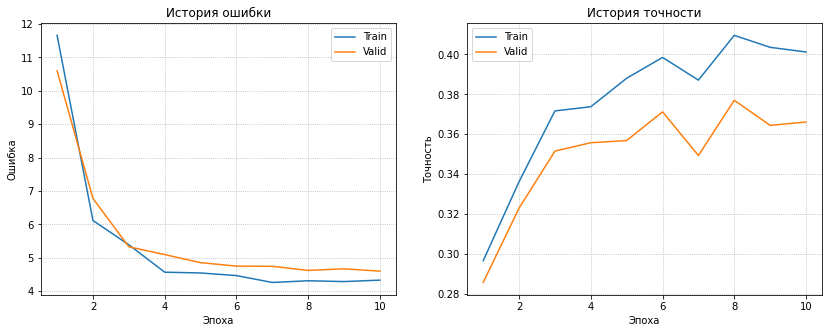


====================================== Validation ======================================/n
Ошибка на тесте: 4.6456
Точность на тесте: 0.3663

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.41      0.26      0.32      1000
           1       0.45      0.44      0.45      1000
           2       0.28      0.29      0.28      1000
           3       0.26      0.28      0.27      1000
           4       0.31      0.23      0.26      1000
           5       0.26      0.23      0.24      1000
           6       0.39      0.49      0.44      1000
           7       0.42      0.41      0.42      1000
           8       0.43      0.58      0.49      1000
           9       0.44      0.45      0.44      1000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.36     10000
weighted avg       0.36      0.37      0.36     100

In [22]:
model = Sequential(
    Linear(3072, 768),
    # ReLU(),
    Linear(768, 128),
    # ReLU(),
    Linear(128, 10)
)
display(model)

pipeline(train_data, valid_data, model, epochs=10, lr=1e-3, optim="Adam", eps=1e-3)

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  9.3454  | 0.2861  |  8.6769  | 0.2805  | 0.009691 |   17.4   |   17.4   |
| 2/10|  6.3120  | 0.3591  |  5.9670  | 0.3434  | 0.005171 |   16.0   |   33.4   |
| 3/10|  5.2877  | 0.3549  |  5.6754  | 0.3420  | 0.004292 |   14.8   |   48.3   |
| 4/10|  4.9816  | 0.3691  |  4.9608  | 0.3509  | 0.002838 |   14.8   |   63.0   |
| 5/10|  4.3263  | 0.4084  |  4.5289  | 0.3916  | 0.001958 |   14.4   |   77.4   |
| 6/10|  4.0200  | 0.4352  |  4.2138  | 0.4038  | 0.001849 |   14.7   |   92.2   |
| 7/10|  3.7486  | 0.4577  |  4.0606  | 0.4188  | 0.001085 |   16.1   |  108.3   |
| 8/10|  3.5019  | 0.4711  |  4.0139  | 0.4224  | 0.000512 |   15.5   |  123.8   |
| 9/10|  3.1450  | 0.4784  |  3.9204  | 0.4290  | 0.000523 |   15.7   |  1

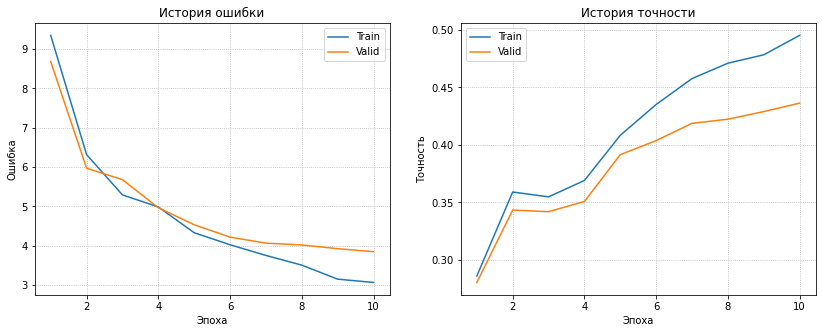


====================================== Validation ======================================/n
Ошибка на тесте: 3.8116
Точность на тесте: 0.4360

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.57      0.45      0.50      1000
           1       0.56      0.45      0.50      1000
           2       0.37      0.32      0.34      1000
           3       0.29      0.29      0.29      1000
           4       0.38      0.33      0.35      1000
           5       0.37      0.36      0.37      1000
           6       0.45      0.51      0.48      1000
           7       0.49      0.49      0.49      1000
           8       0.46      0.67      0.55      1000
           9       0.45      0.50      0.47      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.43     10000
weighted avg       0.44      0.44      0.43     100

In [23]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
model
pipeline(train_data, valid_data, model, epochs=10, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод: 
Как видно, наличие функции активации ReLU положительно влияет на accuracy, модель показывает лучший результат, чем просто полносвязная сеть без активации

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.    

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10| 173.7011 | 0.2685  | 172.8664 | 0.2668  | 0.001137 |   16.2   |   16.2   |
| 2/10| 170.1619 | 0.3019  | 170.1196 | 0.3003  | 0.000464 |   16.3   |   32.5   |
| 3/10| 162.3652 | 0.2971  | 168.7713 | 0.2911  | 0.000406 |   16.5   |   49.0   |
| 4/10| 167.3958 | 0.3062  | 167.4884 | 0.3020  | 0.000353 |   16.7   |   65.7   |
| 5/10| 157.6716 | 0.3387  | 166.3476 | 0.3312  | 0.000318 |   16.4   |   82.1   |
| 6/10| 168.0244 | 0.3461  | 165.2380 | 0.3381  | 0.000333 |   16.6   |   98.7   |
| 7/10| 165.9415 | 0.3480  | 164.1471 | 0.3414  | 0.000322 |   16.7   |  115.3   |
| 8/10| 161.8690 | 0.3546  | 163.0597 | 0.3482  | 0.000315 |   15.5   |  130.8   |
| 9/10| 159.1629 | 0.3598  | 161.9730 | 0.3506  | 0.000308 |   15.5   |  1

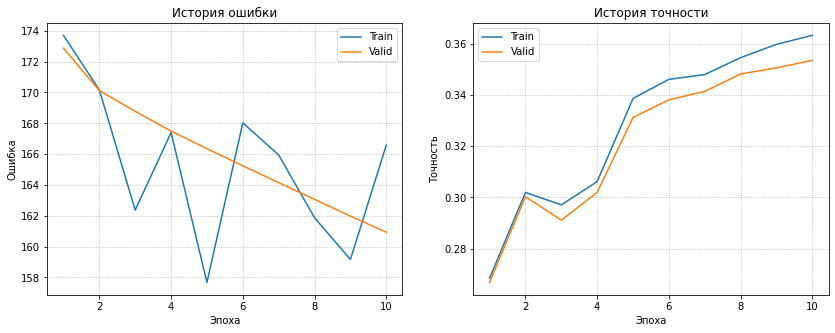


====================================== Validation ======================================/n
Ошибка на тесте: 160.9183
Точность на тесте: 0.3587

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.36      0.56      0.44      1000
           1       0.00      0.00      0.00      1000
           2       0.28      0.15      0.19      1000
           3       0.30      0.28      0.29      1000
           4       0.36      0.36      0.36      1000
           5       0.38      0.28      0.32      1000
           6       0.38      0.50      0.43      1000
           7       0.46      0.35      0.40      1000
           8       0.52      0.41      0.46      1000
           9       0.29      0.70      0.41      1000

    accuracy                           0.36     10000
   macro avg       0.33      0.36      0.33     10000
weighted avg       0.33      0.36      0.33     1

/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

pipeline(train_data, valid_data, model, epochs=10, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод: 
Как видно, наличие функции активации Sigmoid положительно влияет на accuracy, модель показывает лучший результат, чем просто полносвязная сеть без активации, но при этом уступает модели с активацией ReLU

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  6.1375  | 0.2638  |  5.9724  | 0.2582  | 0.009003 |   14.8   |   14.8   |
| 2/10|  5.4948  | 0.3039  |  5.4695  | 0.2982  | 0.009685 |   14.9   |   29.7   |
| 3/10|  4.9843  | 0.3411  |  4.9692  | 0.3346  | 0.007140 |   14.9   |   44.6   |
| 4/10|  4.7501  | 0.3556  |  4.7606  | 0.3503  | 0.004924 |   15.0   |   59.6   |
| 5/10|  4.4942  | 0.3774  |  4.5652  | 0.3669  | 0.001693 |   15.0   |   74.6   |
| 6/10|  4.3656  | 0.3860  |  4.4233  | 0.3737  | 0.001633 |   15.0   |   89.6   |
| 7/10|  4.2569  | 0.3945  |  4.3115  | 0.3828  | 0.001068 |   14.9   |  104.5   |
| 8/10|  4.1482  | 0.4053  |  4.2107  | 0.3921  | 0.001103 |   15.0   |  119.5   |
| 9/10|  4.0321  | 0.4134  |  4.1380  | 0.3973  | 0.001268 |   14.9   |  1

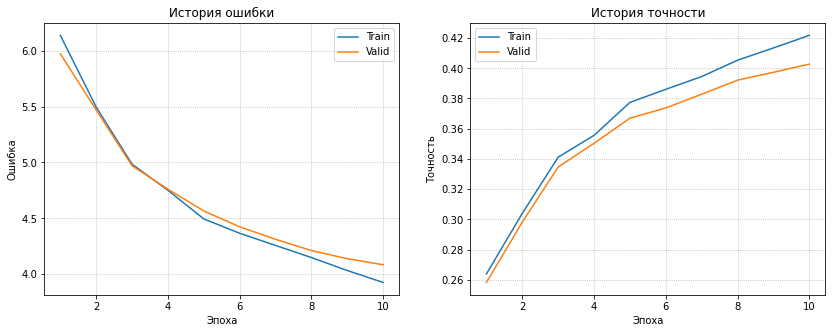


====================================== Validation ======================================/n
Ошибка на тесте: 4.0462
Точность на тесте: 0.4083

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.47      0.47      0.47      1000
           1       0.46      0.42      0.44      1000
           2       0.31      0.24      0.27      1000
           3       0.28      0.29      0.29      1000
           4       0.38      0.35      0.36      1000
           5       0.38      0.30      0.34      1000
           6       0.39      0.52      0.44      1000
           7       0.46      0.42      0.44      1000
           8       0.46      0.58      0.52      1000
           9       0.45      0.49      0.47      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.40     10000
weighted avg       0.41      0.41      0.40     100

In [25]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

pipeline(train_data, valid_data, model, epochs=10, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод: 
Как видно, наличие функции активации Tanh положительно влияет на accuracy, модель показывает лучший результат, чем просто полносвязная сеть без активации и чем модель с активацией Sigmoid, но при этом опять же уступает модели с активацией ReLU

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  5.7959  | 0.1997  |  7.8612  | 0.1987  | 0.006102 |   11.9   |   11.9   |
| 2/10|  4.8584  | 0.2557  |  7.0108  | 0.2525  | 0.001943 |   12.3   |   24.2   |
| 3/10|  4.3317  | 0.2818  |  6.5361  | 0.2805  | 0.001362 |   13.2   |   37.4   |
| 4/10|  4.0643  | 0.2982  |  6.1204  | 0.2938  | 0.000780 |   13.5   |   50.9   |
| 5/10|  3.8397  | 0.2973  |  6.1288  | 0.2966  | 0.000706 |   13.6   |   64.5   |
| 6/10|  3.6304  | 0.3071  |  5.8446  | 0.3022  | 0.000509 |   14.2   |   78.7   |
| 7/10|  3.4144  | 0.3115  |  5.7597  | 0.3054  | 0.000384 |   13.9   |   92.6   |
| 8/10|  3.2888  | 0.3137  |  5.7742  | 0.3057  | 0.000391 |   14.1   |  106.8   |
| 9/10|  3.2204  | 0.3194  |  5.6943  | 0.3124  | 0.000334 |   14.3   |  1

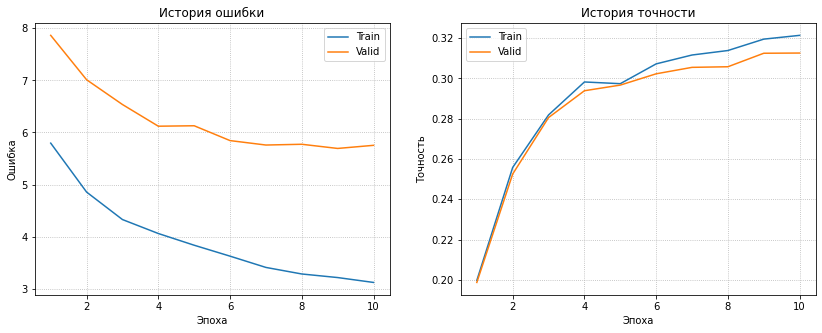


====================================== Validation ======================================/n
Ошибка на тесте: 5.5738
Точность на тесте: 0.3118

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.54      0.23      0.32      1000
           1       0.44      0.32      0.37      1000
           2       0.28      0.13      0.18      1000
           3       0.21      0.30      0.24      1000
           4       0.37      0.20      0.26      1000
           5       0.30      0.24      0.27      1000
           6       0.44      0.14      0.21      1000
           7       0.32      0.46      0.38      1000
           8       0.27      0.65      0.39      1000
           9       0.31      0.44      0.36      1000

    accuracy                           0.31     10000
   macro avg       0.35      0.31      0.30     10000
weighted avg       0.35      0.31      0.30     100

In [28]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.1),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)

pipeline(train_data, valid_data, model, epochs=10, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод: 
Как видно, наличие слоя Dropout отрицательно влияет на accuracy, но при этом сложно не заметить, что лосс модели вначале падает сильнее, чем у модели с функцией активации ReLU. В принципе, это подтверждает ожидания от Dropout, - наличие этого слоя играет роль регуляризатора и уменьшает вероятность переобучения, но при этом сокращается способность модели обобщать данные. Это подтвердлилось в эксперименте

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10| 22.0946  | 0.0703  | 35.0069  | 0.0749  | 0.048992 |   13.9   |   13.9   |
| 2/10| 10.4433  | 0.1509  | 13.6524  | 0.1514  | 0.011819 |   18.2   |   32.1   |
| 3/10|  9.9911  | 0.1719  | 11.0136  | 0.1724  | 0.005737 |   20.0   |   52.0   |
| 4/10|  8.7487  | 0.1759  |  9.0570  | 0.1747  | 0.003488 |   16.8   |   68.9   |
| 5/10|  8.4775  | 0.1627  |  8.6708  | 0.1602  | 0.001772 |   15.9   |   84.8   |
| 6/10|  8.1541  | 0.1652  |  8.1137  | 0.1645  | 0.001562 |   16.1   |  100.8   |
| 7/10|  7.7984  | 0.1724  |  7.7445  | 0.1755  | 0.001335 |   16.2   |  117.0   |
| 8/10|  7.6518  | 0.1828  |  7.5510  | 0.1870  | 0.001003 |   15.5   |  132.6   |
| 9/10|  7.5281  | 0.1815  |  7.5171  | 0.1870  | 0.000949 |   15.5   |  1

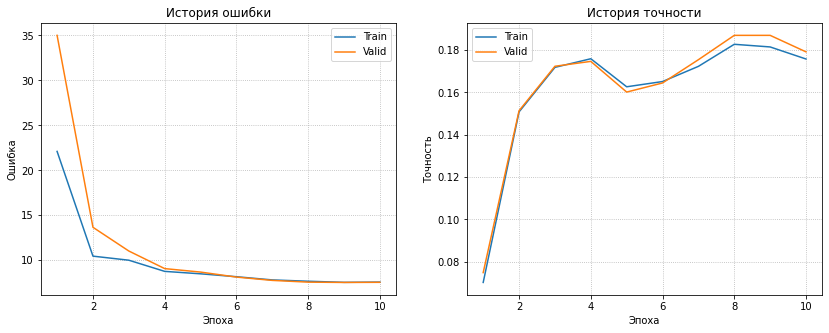


====================================== Validation ======================================/n
Ошибка на тесте: 7.5587
Точность на тесте: 0.1934

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.31      0.34      0.32      1000
           1       0.20      0.14      0.17      1000
           2       0.02      0.00      0.00      1000
           3       0.17      0.09      0.12      1000
           4       0.11      0.29      0.16      1000
           5       0.17      0.19      0.18      1000
           6       0.23      0.25      0.24      1000
           7       0.14      0.17      0.15      1000
           8       0.32      0.25      0.28      1000
           9       0.28      0.20      0.23      1000

    accuracy                           0.19     10000
   macro avg       0.19      0.19      0.19     10000
weighted avg       0.19      0.19      0.19     100

In [20]:
model = Sequential(
    # BatchNorm(3072),
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
display(model)

pipeline(train_data, valid_data, model, epochs=10, lr=3e-3, optim="Adam", eps=1e-3)

#### Вывод
Как видно, я скорее всего не очень корректно реализовал BatchNorm слой, поэтому качество не такое высокое, но при этом модель обучается, что свидетельствует о том, что не так уж я и непраильно это реализовал. Так как я потратил на домашку 5 дней, то доделывать я это, конечно же, не буду

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### Сначала обучим модель с обычным градиентным спуском:

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  8.0660  | 0.1891  |  7.6038  | 0.1937  | 0.090168 |   11.5   |   11.5   |
| 2/10|  6.7958  | 0.2357  |  6.6458  | 0.2383  | 0.039353 |   11.7   |   23.2   |
| 3/10|  6.2569  | 0.2600  |  6.1843  | 0.2613  | 0.024382 |   12.2   |   35.3   |
| 4/10|  5.9368  | 0.2797  |  5.8858  | 0.2765  | 0.019822 |   12.6   |   47.9   |
| 5/10|  5.6509  | 0.2939  |  5.6687  | 0.2876  | 0.017967 |   13.1   |   61.0   |
| 6/10|  5.4635  | 0.3054  |  5.4993  | 0.2986  | 0.015893 |   13.5   |   74.5   |
| 7/10|  5.3255  | 0.3164  |  5.3615  | 0.3075  | 0.013842 |   15.7   |   90.2   |
| 8/10|  5.1984  | 0.3237  |  5.2479  | 0.3166  | 0.014218 |   17.1   |  107.3   |
| 9/10|  5.1099  | 0.3322  |  5.1516  | 0.3241  | 0.011970 |   16.1   |  1

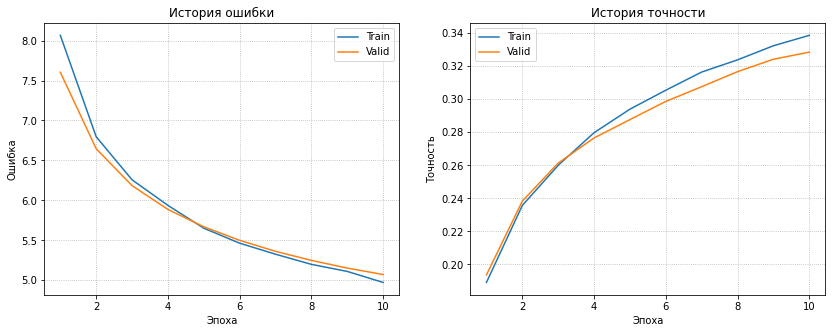


====================================== Validation ======================================/n
Ошибка на тесте: 5.0567
Точность на тесте: 0.3302

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.45      0.41      0.43      1000
           1       0.40      0.34      0.37      1000
           2       0.25      0.18      0.21      1000
           3       0.22      0.23      0.22      1000
           4       0.26      0.28      0.27      1000
           5       0.27      0.29      0.28      1000
           6       0.33      0.35      0.34      1000
           7       0.34      0.28      0.31      1000
           8       0.41      0.48      0.44      1000
           9       0.36      0.45      0.40      1000

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.33      0.33      0.33     100

In [21]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=10, lr=3e-3, optim="GD", eps=1e-3)

#### Теперь обучим модель с Adam в качестве оптимайзера:

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  8.5226  | 0.2959  |  9.1659  | 0.2873  | 0.008036 |   15.2   |   15.2   |
| 2/10|  6.9478  | 0.3452  |  6.2877  | 0.3452  | 0.006884 |   15.5   |   30.7   |
| 3/10|  5.3995  | 0.3581  |  5.2732  | 0.3451  | 0.003542 |   15.6   |   46.3   |
| 4/10|  4.7748  | 0.3731  |  4.9076  | 0.3539  | 0.002410 |   15.2   |   61.5   |
| 5/10|  4.2835  | 0.4011  |  4.5771  | 0.3744  | 0.001694 |   15.0   |   76.5   |
| 6/10|  3.9020  | 0.4316  |  4.2751  | 0.3982  | 0.000954 |   15.1   |   91.6   |
| 7/10|  3.7176  | 0.4524  |  4.1393  | 0.4096  | 0.000829 |   15.7   |  107.3   |
| 8/10|  3.4632  | 0.4662  |  4.0216  | 0.4225  | 0.001005 |   16.2   |  123.5   |
| 9/10|  3.2895  | 0.4810  |  3.9390  | 0.4271  | 0.000914 |   16.0   |  1

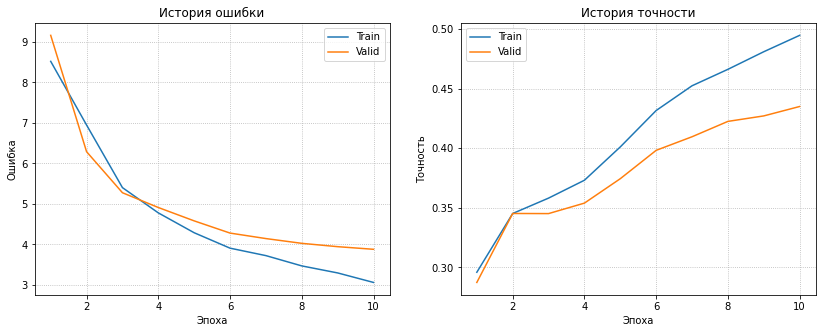


====================================== Validation ======================================/n
Ошибка на тесте: 3.8480
Точность на тесте: 0.4364

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.59      0.44      0.50      1000
           1       0.53      0.46      0.49      1000
           2       0.35      0.33      0.34      1000
           3       0.32      0.24      0.28      1000
           4       0.38      0.33      0.35      1000
           5       0.35      0.40      0.38      1000
           6       0.42      0.58      0.49      1000
           7       0.50      0.44      0.47      1000
           8       0.52      0.58      0.55      1000
           9       0.43      0.55      0.48      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.43     10000
weighted avg       0.44      0.44      0.43     100

In [24]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=10, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод
Как видно, лучше себя показывает оптимизатор Adam. Стоит ли объяснять, почему? С ним модель быстрее сходится + он позволяет выводить модель из седловых точек и локальных минимумов

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

Число эпох подбиралось таким образом, чтобы качество на валидации точно вышло на плато

#### Меньше слоев

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/40|  6.2587  | 0.4036  |  5.7967  | 0.3806  | 0.002973 |   14.3   |   14.3   |
| 2/40|  3.8112  | 0.4704  |  4.4530  | 0.4223  | 0.003698 |   14.2   |   28.5   |
| 3/40|  3.2959  | 0.5336  |  3.9295  | 0.4545  | 0.002188 |   14.4   |   43.0   |
| 4/40|  2.7906  | 0.5693  |  3.7833  | 0.4744  | 0.001349 |   15.0   |   58.0   |
| 5/40|  2.4983  | 0.5912  |  3.6757  | 0.4703  | 0.001489 |   15.5   |   73.5   |
| 6/40|  2.0945  | 0.6182  |  3.6857  | 0.4691  | 0.000887 |   14.7   |   88.2   |
| 7/40|  2.0525  | 0.6333  |  3.6212  | 0.4736  | 0.001165 |   14.6   |  102.7   |
| 8/40|  1.8639  | 0.6601  |  3.5491  | 0.4754  | 0.001261 |   15.0   |  117.8   |
| 9/40|  1.5096  | 0.6907  |  3.4718  | 0.4828  | 0.000656 |   15.1   |  1

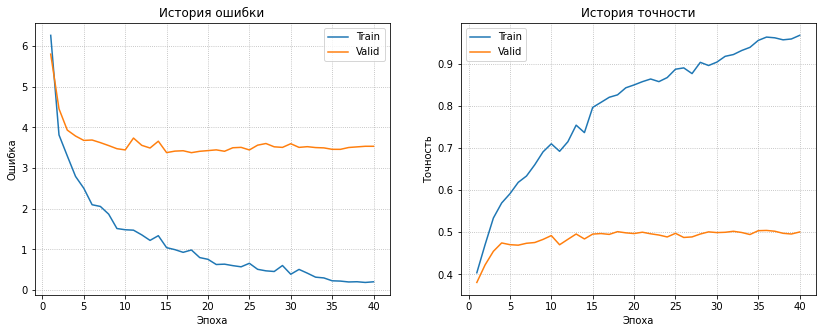


====================================== Validation ======================================/n
Ошибка на тесте: 3.4696
Точность на тесте: 0.5045

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1000
           1       0.65      0.51      0.57      1000
           2       0.42      0.37      0.39      1000
           3       0.33      0.37      0.35      1000
           4       0.44      0.41      0.43      1000
           5       0.41      0.41      0.41      1000
           6       0.57      0.52      0.54      1000
           7       0.58      0.56      0.57      1000
           8       0.61      0.67      0.64      1000
           9       0.50      0.57      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.51      0.50      0.50     100

In [24]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 10),
)
display(model)
pipeline(train_data, valid_data, model, epochs=40, lr=1e-3, optim="Adam", eps=1e-3)

#### Нужно больше слоев

Sequential(
	Linear(3072, 512, bias=True),
	ReLU(),
	Linear(512, 256, bias=True),
	ReLU(),
	Linear(256, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/40|  4.4519  | 0.4088  |  4.4681  | 0.3809  | 0.001894 |   11.8   |   11.8   |
| 2/40|  3.6590  | 0.4712  |  3.9217  | 0.4224  | 0.001605 |   11.7   |   23.5   |
| 3/40|  3.1253  | 0.5112  |  3.7928  | 0.4398  | 0.000814 |   11.7   |   35.1   |
| 4/40|  2.7910  | 0.5473  |  3.6485  | 0.4527  | 0.000540 |   11.5   |   46.7   |
| 5/40|  2.4787  | 0.5798  |  3.6277  | 0.4565  | 0.000712 |   11.8   |   58.4   |
| 6/40|  2.2080  | 0.6069  |  3.5928  | 0.4632  | 0.000450 |   11.8   |   70.2   |
| 7/40|  1.9662  | 0.6360  |  3.6170  | 0.4642  | 0.000435 |   11.5   |   81.8   |
| 8/40|  1.6436  | 0.6655  |  3.5833  | 0.4648  | 0.000387 |   11.6   |   93.4   |
| 9/40|  1.6303  | 0.6939  |  3.5879  | 0.4683  | 0.000315 |   11.6   |  1

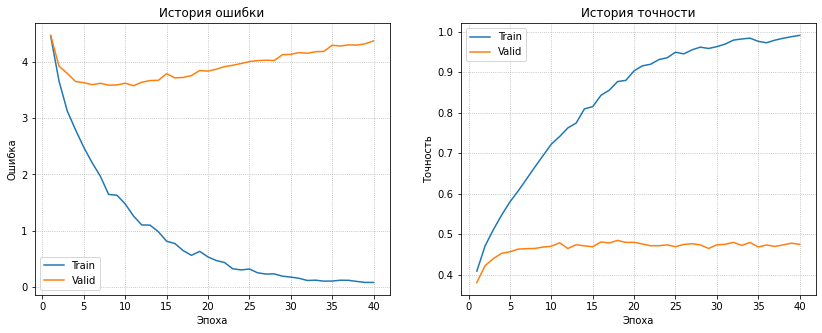


====================================== Validation ======================================/n
Ошибка на тесте: 4.2454
Точность на тесте: 0.4762

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.52      0.59      0.56      1000
           1       0.60      0.51      0.55      1000
           2       0.37      0.37      0.37      1000
           3       0.31      0.36      0.33      1000
           4       0.41      0.42      0.41      1000
           5       0.39      0.35      0.37      1000
           6       0.52      0.52      0.52      1000
           7       0.55      0.51      0.53      1000
           8       0.59      0.62      0.60      1000
           9       0.55      0.50      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     100

In [25]:
model = Sequential(
    Linear(3072, 512),
    ReLU(),
    Linear(512, 256),
    ReLU(),
    Linear(256, 128),
    ReLU(),
    Linear(128, 10),
)
display(model)
pipeline(train_data, valid_data, model, epochs=40, lr=1e-3, optim="Adam", eps=1e-3)

#### Априорное число слоев

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/40|  4.3754  | 0.3996  |  4.5482  | 0.3750  | 0.003184 |   15.7   |   15.7   |
| 2/40|  3.8649  | 0.4634  |  4.0025  | 0.4134  | 0.001617 |   16.1   |   31.8   |
| 3/40|  3.3043  | 0.5040  |  3.8483  | 0.4338  | 0.001336 |   15.8   |   47.5   |
| 4/40|  2.8420  | 0.5397  |  3.6625  | 0.4475  | 0.001339 |   15.7   |   63.2   |
| 5/40|  2.5089  | 0.5765  |  3.5704  | 0.4639  | 0.000646 |   15.6   |   78.8   |
| 6/40|  2.3616  | 0.6062  |  3.4949  | 0.4681  | 0.000481 |   15.6   |   94.5   |
| 7/40|  2.0755  | 0.6282  |  3.4961  | 0.4702  | 0.000585 |   15.5   |  110.0   |
| 8/40|  1.9172  | 0.6468  |  3.4964  | 0.4676  | 0.000647 |   15.6   |  125.6   |
| 9/40|  1.6871  | 0.6787  |  3.4062  | 0.4798  | 0.000302 |   15.8   |  1

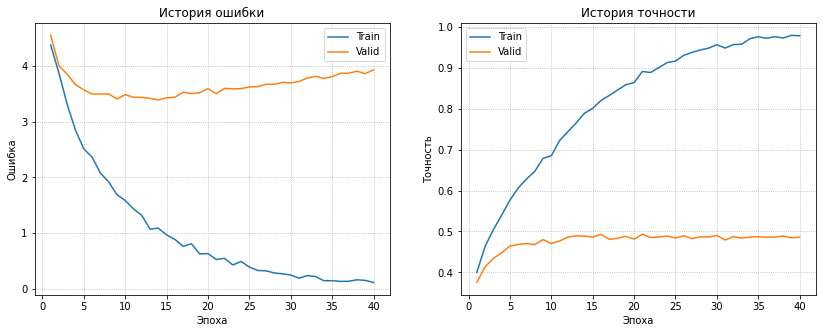


====================================== Validation ======================================/n
Ошибка на тесте: 3.8868
Точность на тесте: 0.4857

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1000
           1       0.59      0.55      0.57      1000
           2       0.41      0.36      0.38      1000
           3       0.34      0.31      0.33      1000
           4       0.37      0.42      0.39      1000
           5       0.40      0.40      0.40      1000
           6       0.50      0.61      0.55      1000
           7       0.56      0.53      0.54      1000
           8       0.61      0.64      0.63      1000
           9       0.50      0.50      0.50      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     100

In [26]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10),
)
display(model)
pipeline(train_data, valid_data, model, epochs=40, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод
Вывод кажется не очень интуитивно понятным, но все же. Меньшее количество слоев показывает наилучшее качество. Затем идет трехслойная сеть, затем сеть в четырьмя слоями. Более того, из графиков для метрик видно, что модели с тремя и четырьмя слоями начали переобучаться

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

#### Больше нейронов

Sequential(
	Linear(3072, 1536, bias=True),
	ReLU(),
	Linear(1536, 512, bias=True),
	ReLU(),
	Linear(512, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.6267  | 0.3740  |  4.5929  | 0.3540  | 0.002414 |   29.2   |   29.2   |
| 2/15|  3.5471  | 0.4648  |  3.9191  | 0.4277  | 0.001742 |   30.2   |   59.4   |
| 3/15|  3.0909  | 0.5242  |  3.6047  | 0.4570  | 0.001083 |   30.8   |   90.3   |
| 4/15|  2.7773  | 0.5515  |  3.5566  | 0.4585  | 0.000922 |   30.7   |  121.0   |
| 5/15|  2.4538  | 0.5925  |  3.4503  | 0.4679  | 0.000732 |   30.6   |  151.6   |
| 6/15|  2.1360  | 0.6288  |  3.4052  | 0.4795  | 0.000637 |   35.6   |  187.2   |
| 7/15|  1.9039  | 0.6611  |  3.3500  | 0.4888  | 0.000684 |   31.0   |  218.2   |
| 8/15|  1.5947  | 0.6907  |  3.3733  | 0.4889  | 0.000397 |   30.5   |  248.7   |
| 9/15|  1.4397  | 0.7261  |  3.3476  | 0.4904  | 0.000421 |   30.4   |  2

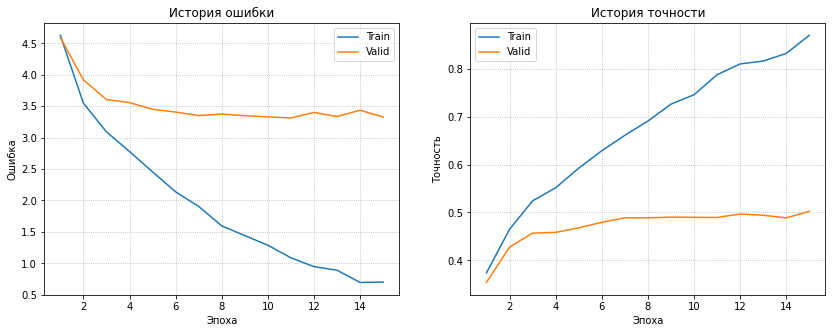


====================================== Validation ======================================/n
Ошибка на тесте: 3.2305
Точность на тесте: 0.4987

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1000
           1       0.61      0.62      0.62      1000
           2       0.39      0.38      0.39      1000
           3       0.35      0.31      0.33      1000
           4       0.39      0.49      0.43      1000
           5       0.40      0.42      0.41      1000
           6       0.59      0.43      0.50      1000
           7       0.54      0.57      0.55      1000
           8       0.62      0.65      0.64      1000
           9       0.55      0.52      0.53      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     100

In [29]:
model = Sequential(
    Linear(3072, 1536),
    ReLU(),
    Linear(1536, 512),
    ReLU(),
    Linear(512, 10),
)
display(model)
pipeline(train_data, valid_data, model, epochs=15, lr=1e-3, optim="Adam", eps=1e-3, check_grads=False)

#### Меньше нейронов

Sequential(
	Linear(3072, 512, bias=True),
	ReLU(),
	Linear(512, 64, bias=True),
	ReLU(),
	Linear(64, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.0539  | 0.3807  |  4.7879  | 0.3615  | 0.003112 |   10.1   |   10.1   |
| 2/15|  3.9609  | 0.4471  |  4.2443  | 0.4001  | 0.002466 |   10.1   |   20.3   |
| 3/15|  3.3230  | 0.4935  |  3.9853  | 0.4290  | 0.001560 |   10.1   |   30.4   |
| 4/15|  3.1184  | 0.5137  |  3.9436  | 0.4283  | 0.000856 |   10.2   |   40.6   |
| 5/15|  3.0302  | 0.5391  |  3.8562  | 0.4444  | 0.000907 |   11.8   |   52.4   |
| 6/15|  2.4330  | 0.5709  |  3.7682  | 0.4500  | 0.000672 |   11.8   |   64.2   |
| 7/15|  2.4212  | 0.5884  |  3.7260  | 0.4530  | 0.000587 |   11.8   |   76.0   |
| 8/15|  2.1602  | 0.6228  |  3.6418  | 0.4638  | 0.000479 |   10.4   |   86.4   |
| 9/15|  1.9395  | 0.6360  |  3.6599  | 0.4642  | 0.000325 |   10.2   |   

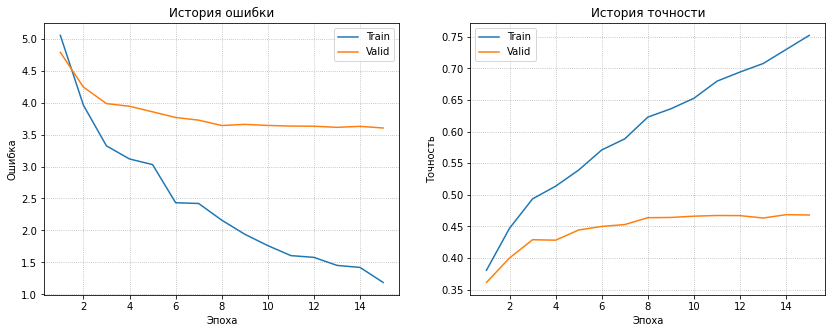


====================================== Validation ======================================/n
Ошибка на тесте: 3.5654
Точность на тесте: 0.4798

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.54      0.59      0.56      1000
           1       0.59      0.55      0.57      1000
           2       0.39      0.38      0.38      1000
           3       0.33      0.31      0.32      1000
           4       0.41      0.38      0.40      1000
           5       0.37      0.42      0.39      1000
           6       0.52      0.54      0.53      1000
           7       0.59      0.48      0.53      1000
           8       0.61      0.60      0.60      1000
           9       0.49      0.55      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     100

In [30]:
model = Sequential(
    Linear(3072, 512),
    ReLU(),
    Linear(512, 64),
    ReLU(),
    Linear(64, 10),
)
display(model)
pipeline(train_data, valid_data, model, epochs=15, lr=1e-3, optim="Adam", eps=1e-3, check_grads=False)

#### Вывод
Здесь результат допольно закономерный: при увеличении количества нейронов обобщательная способность модели увеличивается, в результате чего и повышается качество классификации

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

#### Batch_size=1000

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  4.5017  | 0.4255  |  4.3311  | 0.3942  | 0.002224 |   12.9   |   12.9   |
| 2/20|  3.4863  | 0.4950  |  3.8571  | 0.4378  | 0.000997 |   13.2   |   26.1   |
| 3/20|  3.0472  | 0.5306  |  3.7266  | 0.4552  | 0.000928 |   13.4   |   39.5   |
| 4/20|  2.9326  | 0.5605  |  3.6815  | 0.4570  | 0.000603 |   13.9   |   53.4   |
| 5/20|  2.4450  | 0.5933  |  3.6708  | 0.4684  | 0.000422 |   14.1   |   67.5   |
| 6/20|  2.2643  | 0.6189  |  3.6160  | 0.4705  | 0.000509 |   14.4   |   81.9   |
| 7/20|  1.7938  | 0.6524  |  3.5519  | 0.4753  | 0.000416 |   14.6   |   96.6   |
| 8/20|  1.6555  | 0.6772  |  3.5472  | 0.4813  | 0.000309 |   14.7   |  111.3   |
| 9/20|  1.5627  | 0.7070  |  3.5453  | 0.4832  | 0.000331 |   14.9   |  1

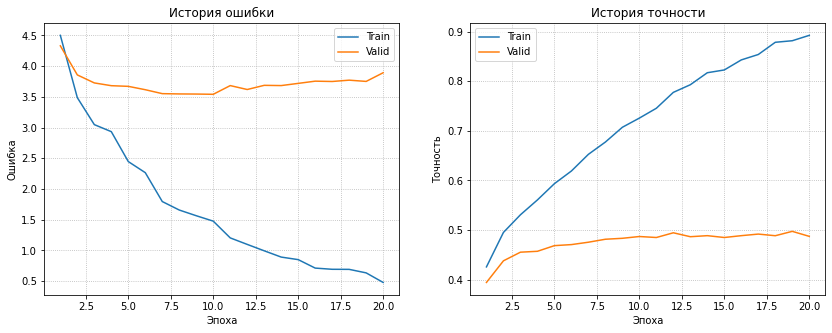


====================================== Validation ======================================/n
Ошибка на тесте: 3.9018
Точность на тесте: 0.4767

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.61      0.53      0.56      1000
           1       0.56      0.62      0.59      1000
           2       0.38      0.38      0.38      1000
           3       0.30      0.33      0.32      1000
           4       0.41      0.37      0.39      1000
           5       0.39      0.38      0.39      1000
           6       0.52      0.52      0.52      1000
           7       0.48      0.55      0.51      1000
           8       0.60      0.61      0.60      1000
           9       0.54      0.48      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     100

In [32]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=1000)

#### Batch_size=5000

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  6.1507  | 0.3460  |  5.8927  | 0.3341  | 0.007325 |   14.0   |   14.0   |
| 2/20|  4.7410  | 0.3892  |  4.7900  | 0.3655  | 0.003889 |   13.7   |   27.8   |
| 3/20|  4.0285  | 0.4266  |  4.3558  | 0.3968  | 0.003155 |   13.8   |   41.6   |
| 4/20|  3.5838  | 0.4469  |  4.1314  | 0.4070  | 0.002274 |   15.1   |   56.7   |
| 5/20|  3.2552  | 0.4777  |  4.0107  | 0.4234  | 0.001659 |   16.4   |   73.1   |
| 6/20|  3.1011  | 0.5090  |  3.8658  | 0.4354  | 0.001608 |   15.9   |   89.0   |
| 7/20|  2.7000  | 0.5335  |  3.7652  | 0.4445  | 0.000902 |   14.1   |  103.1   |
| 8/20|  2.6345  | 0.5495  |  3.7477  | 0.4436  | 0.001108 |   14.0   |  117.1   |
| 9/20|  2.3101  | 0.5603  |  3.7407  | 0.4419  | 0.000860 |   14.0   |  1

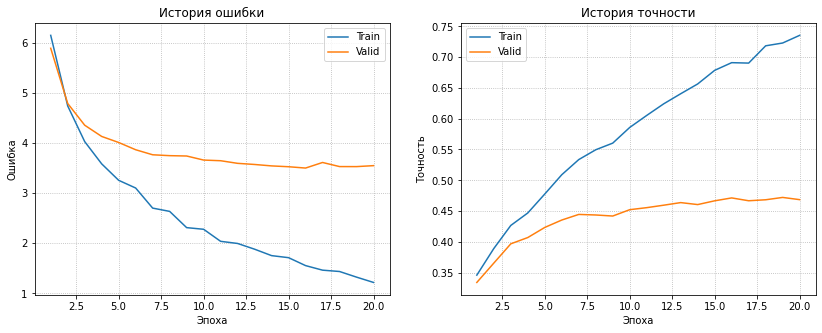


====================================== Validation ======================================/n
Ошибка на тесте: 3.4804
Точность на тесте: 0.4806

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1000
           1       0.57      0.58      0.58      1000
           2       0.38      0.40      0.39      1000
           3       0.33      0.30      0.32      1000
           4       0.40      0.43      0.41      1000
           5       0.42      0.38      0.40      1000
           6       0.51      0.57      0.54      1000
           7       0.57      0.48      0.52      1000
           8       0.59      0.61      0.60      1000
           9       0.52      0.54      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     100

In [33]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=5000)

#### Batch_size=10000

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  8.9599  | 0.3160  |  7.3697  | 0.2992  | 0.018465 |   14.7   |   14.7   |
| 2/20|  5.8128  | 0.3506  |  5.6873  | 0.3314  | 0.012528 |   14.6   |   29.2   |
| 3/20|  4.9300  | 0.3815  |  4.8670  | 0.3624  | 0.008113 |   14.6   |   43.9   |
| 4/20|  4.3674  | 0.4017  |  4.5265  | 0.3784  | 0.002107 |   15.1   |   58.9   |
| 5/20|  4.0312  | 0.4256  |  4.3386  | 0.3984  | 0.002489 |   14.6   |   73.6   |
| 6/20|  3.7415  | 0.4397  |  4.1317  | 0.4076  | 0.001869 |   14.6   |   88.2   |
| 7/20|  3.4627  | 0.4605  |  3.9847  | 0.4216  | 0.002148 |   14.6   |  102.8   |
| 8/20|  3.2469  | 0.4851  |  3.8884  | 0.4307  | 0.001364 |   14.6   |  117.4   |
| 9/20|  3.0999  | 0.5013  |  3.7857  | 0.4372  | 0.001047 |   14.5   |  1

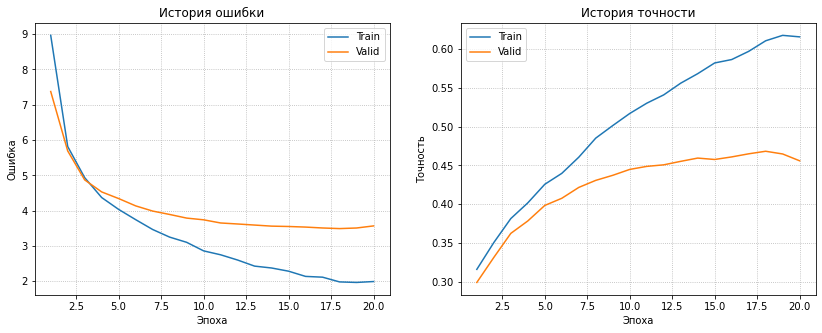


====================================== Validation ======================================/n
Ошибка на тесте: 3.5459
Точность на тесте: 0.4614

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.53      0.42      0.47      1000
           1       0.57      0.54      0.55      1000
           2       0.39      0.36      0.38      1000
           3       0.33      0.31      0.32      1000
           4       0.40      0.36      0.38      1000
           5       0.40      0.37      0.38      1000
           6       0.49      0.58      0.53      1000
           7       0.51      0.53      0.52      1000
           8       0.47      0.73      0.57      1000
           9       0.53      0.41      0.46      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     100

In [34]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000)

#### Batch_size=20000

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20| 15.0426  | 0.2732  | 12.4306  | 0.2709  | 0.032514 |   14.9   |   14.9   |
| 2/20| 10.5156  | 0.3180  |  8.1335  | 0.3054  | 0.018943 |   16.6   |   31.5   |
| 3/20|  7.4631  | 0.3079  |  7.0777  | 0.2997  | 0.007231 |   17.2   |   48.7   |
| 4/20|  6.0504  | 0.3365  |  5.8401  | 0.3230  | 0.003272 |   16.1   |   64.8   |
| 5/20|  5.3973  | 0.3521  |  5.4123  | 0.3373  | 0.005110 |   14.7   |   79.4   |
| 6/20|  4.9695  | 0.3650  |  5.0653  | 0.3433  | 0.003652 |   14.8   |   94.3   |
| 7/20|  4.6771  | 0.3690  |  4.8641  | 0.3472  | 0.002455 |   14.7   |  108.9   |
| 8/20|  4.4295  | 0.3885  |  4.6610  | 0.3636  | 0.003282 |   14.6   |  123.5   |
| 9/20|  4.2357  | 0.4070  |  4.5147  | 0.3833  | 0.001532 |   14.6   |  1

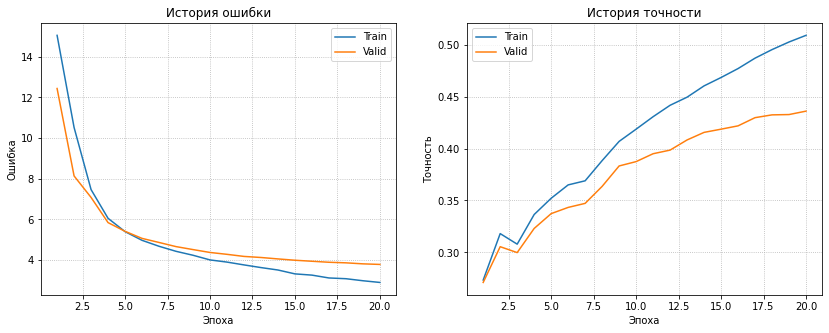


====================================== Validation ======================================/n
Ошибка на тесте: 3.7357
Точность на тесте: 0.4481

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      1000
           1       0.53      0.56      0.54      1000
           2       0.38      0.28      0.33      1000
           3       0.29      0.33      0.31      1000
           4       0.38      0.39      0.38      1000
           5       0.36      0.35      0.35      1000
           6       0.47      0.49      0.48      1000
           7       0.54      0.47      0.50      1000
           8       0.54      0.58      0.56      1000
           9       0.50      0.49      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     100

In [35]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=20000)

#### Вывод
Из экспериментов выше можно увидеть, что размер батча не влияет(или влияет, но крайне мало) на время обучения модели. При этом, скорость схождения модел намного выше при маленьких размерах батча. Тут однозначный вывод: небольшой размер батча положительно влияет на сходимость модели

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

####  Alpha1 = 0, Alpha2 = 0

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  8.2296  | 0.2961  |  7.0728  | 0.2838  | 0.013732 |   11.8   |   11.8   |
| 2/20|  5.5410  | 0.3617  |  5.3406  | 0.3448  | 0.006549 |   11.5   |   23.3   |
| 3/20|  4.8269  | 0.3810  |  4.8715  | 0.3552  | 0.005130 |   12.0   |   35.4   |
| 4/20|  4.4294  | 0.4068  |  4.5427  | 0.3793  | 0.004892 |   12.3   |   47.7   |
| 5/20|  4.0570  | 0.4288  |  4.2788  | 0.4014  | 0.001967 |   12.8   |   60.5   |
| 6/20|  3.7204  | 0.4491  |  4.1468  | 0.4103  | 0.001720 |   13.0   |   73.5   |
| 7/20|  3.5707  | 0.4671  |  3.9898  | 0.4227  | 0.002071 |   13.2   |   86.6   |
| 8/20|  3.2892  | 0.4796  |  3.9209  | 0.4234  | 0.001636 |   13.4   |  100.1   |
| 9/20|  3.1163  | 0.4980  |  3.8600  | 0.4331  | 0.001467 |   13.4   |  1

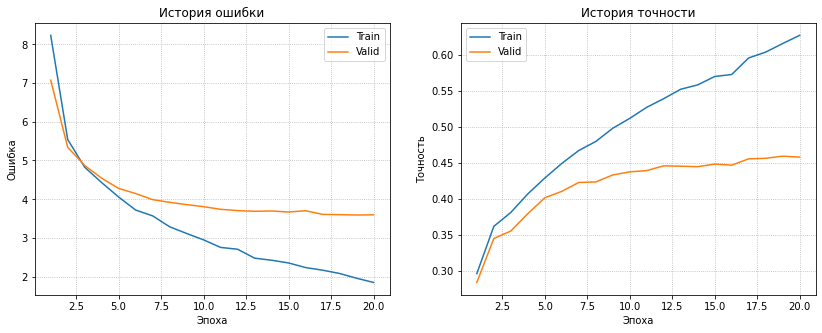


====================================== Validation ======================================/n
Ошибка на тесте: 3.5852
Точность на тесте: 0.4637

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.49      0.61      0.55      1000
           1       0.54      0.57      0.56      1000
           2       0.34      0.31      0.33      1000
           3       0.32      0.32      0.32      1000
           4       0.37      0.40      0.39      1000
           5       0.40      0.36      0.38      1000
           6       0.49      0.53      0.51      1000
           7       0.58      0.48      0.52      1000
           8       0.61      0.59      0.60      1000
           9       0.50      0.48      0.49      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     100

In [38]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000, alpha1=0, alpha2=0)

####  Alpha1 = 0.0001, Alpha2 = 0.0001

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  8.0863  | 0.3224  |  7.5865  | 0.3187  | 0.010325 |   15.5   |   15.5   |
| 2/20|  6.0868  | 0.3490  |  5.7715  | 0.3468  | 0.008893 |   15.3   |   30.8   |
| 3/20|  4.8827  | 0.3833  |  5.0581  | 0.3661  | 0.005675 |   15.3   |   46.1   |
| 4/20|  4.3607  | 0.3984  |  4.6111  | 0.3788  | 0.003416 |   15.2   |   61.4   |
| 5/20|  4.0711  | 0.4293  |  4.3597  | 0.3966  | 0.003757 |   15.3   |   76.6   |
| 6/20|  3.7002  | 0.4516  |  4.1986  | 0.4101  | 0.001672 |   15.4   |   92.0   |
| 7/20|  3.3659  | 0.4661  |  3.9979  | 0.4245  | 0.001690 |   15.3   |  107.3   |
| 8/20|  3.2238  | 0.4893  |  3.8259  | 0.4404  | 0.001590 |   15.3   |  122.6   |
| 9/20|  3.0420  | 0.5019  |  3.7705  | 0.4421  | 0.001392 |   15.4   |  1

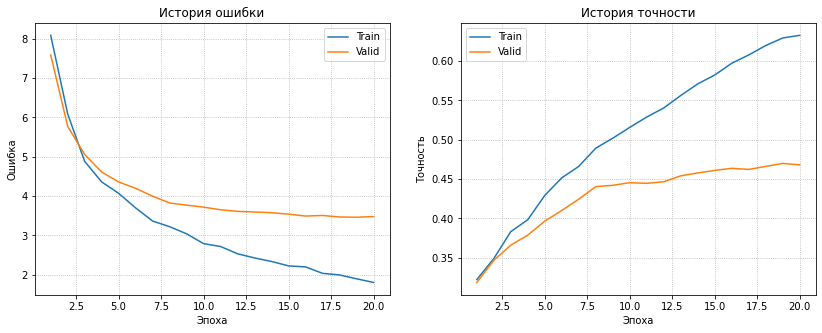


====================================== Validation ======================================/n
Ошибка на тесте: 3.4019
Точность на тесте: 0.4782

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.49      0.65      0.56      1000
           1       0.58      0.56      0.57      1000
           2       0.40      0.33      0.36      1000
           3       0.33      0.33      0.33      1000
           4       0.44      0.38      0.40      1000
           5       0.40      0.32      0.36      1000
           6       0.46      0.58      0.51      1000
           7       0.54      0.53      0.54      1000
           8       0.61      0.60      0.61      1000
           9       0.51      0.50      0.50      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     100

In [44]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000, alpha1=1e-4, alpha2=1e-4)

####  Alpha1 = 0.001, Alpha2 = 0.001

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  8.3004  | 0.3278  |  6.8904  | 0.3190  | 0.019046 |   17.3   |   17.3   |
| 2/20|  5.7515  | 0.3429  |  5.5000  | 0.3293  | 0.008686 |   15.2   |   32.5   |
| 3/20|  4.5908  | 0.3874  |  4.8077  | 0.3688  | 0.003620 |   14.4   |   46.9   |
| 4/20|  4.1244  | 0.3993  |  4.4521  | 0.3763  | 0.002612 |   14.4   |   61.3   |
| 5/20|  3.7964  | 0.4252  |  4.1915  | 0.3969  | 0.002451 |   14.7   |   76.0   |
| 6/20|  3.5803  | 0.4476  |  4.0367  | 0.4091  | 0.001872 |   14.5   |   90.4   |
| 7/20|  3.3746  | 0.4699  |  3.8835  | 0.4221  | 0.001525 |   14.7   |  105.1   |
| 8/20|  3.2259  | 0.4883  |  3.7711  | 0.4361  | 0.001488 |   15.4   |  120.5   |
| 9/20|  3.0030  | 0.5037  |  3.6901  | 0.4397  | 0.001993 |   14.9   |  1

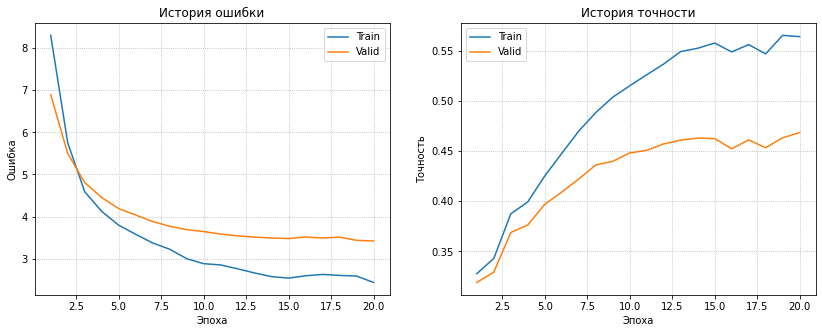


====================================== Validation ======================================/n
Ошибка на тесте: 3.3740
Точность на тесте: 0.4812

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1000
           1       0.61      0.49      0.54      1000
           2       0.37      0.33      0.35      1000
           3       0.35      0.32      0.34      1000
           4       0.41      0.43      0.42      1000
           5       0.45      0.34      0.39      1000
           6       0.45      0.64      0.52      1000
           7       0.54      0.52      0.53      1000
           8       0.59      0.62      0.60      1000
           9       0.49      0.57      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     100

In [39]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000, alpha1=1e-3, alpha2=1e-3)

####  Alpha1 = 0.01, Alpha2 = 0.01

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  6.9834  | 0.3177  |  6.1192  | 0.3083  | 0.012245 |   14.8   |   14.8   |
| 2/20|  5.0822  | 0.3413  |  4.9584  | 0.3403  | 0.004696 |   14.8   |   29.6   |
| 3/20|  4.6007  | 0.3688  |  4.6480  | 0.3559  | 0.006117 |   14.8   |   44.5   |
| 4/20|  4.3771  | 0.3933  |  4.4832  | 0.3793  | 0.003279 |   14.8   |   59.3   |
| 5/20|  4.2509  | 0.4023  |  4.4096  | 0.3871  | 0.002552 |   14.9   |   74.2   |
| 6/20|  4.1742  | 0.4127  |  4.3419  | 0.3922  | 0.002722 |   15.5   |   89.7   |
| 7/20|  4.1121  | 0.4124  |  4.3084  | 0.3942  | 0.002317 |   15.1   |  104.8   |
| 8/20|  4.0759  | 0.4170  |  4.2832  | 0.3939  | 0.002536 |   14.8   |  119.6   |
| 9/20|  4.0615  | 0.4197  |  4.2685  | 0.3985  | 0.002492 |   14.9   |  1

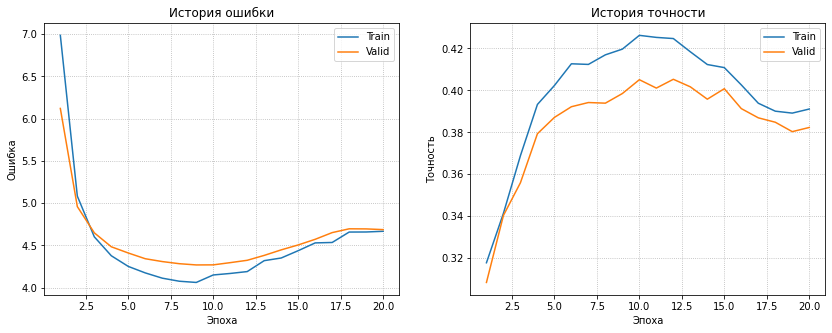


====================================== Validation ======================================/n
Ошибка на тесте: 4.6618
Точность на тесте: 0.3923

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.46      0.42      0.44      1000
           1       0.44      0.44      0.44      1000
           2       0.33      0.20      0.25      1000
           3       0.30      0.24      0.27      1000
           4       0.39      0.29      0.33      1000
           5       0.36      0.36      0.36      1000
           6       0.36      0.53      0.43      1000
           7       0.40      0.42      0.41      1000
           8       0.42      0.53      0.47      1000
           9       0.42      0.48      0.45      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     100

In [40]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000, alpha1=1e-2, alpha2=1e-2)

####  Alpha1 = 0.1, Alpha2 = 0.1

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  8.4553  | 0.1558  |  8.0499  | 0.1534  | 0.015446 |   15.0   |   15.0   |
| 2/20|  7.5414  | 0.1921  |  7.2632  | 0.1889  | 0.011782 |   14.8   |   29.8   |
| 3/20|  7.0233  | 0.2127  |  6.9219  | 0.2096  | 0.015561 |   15.4   |   45.2   |
| 4/20|  6.7374  | 0.2350  |  6.6555  | 0.2342  | 0.019076 |   15.1   |   60.4   |
| 5/20|  6.5456  | 0.2557  |  6.5123  | 0.2558  | 0.016856 |   15.1   |   75.4   |
| 6/20|  6.5303  | 0.2673  |  6.4865  | 0.2667  | 0.022135 |   15.1   |   90.5   |
| 7/20|  6.4921  | 0.2705  |  6.5258  | 0.2682  | 0.025579 |   15.2   |  105.7   |
| 8/20|  6.6063  | 0.2692  |  6.6222  | 0.2694  | 0.028279 |   15.2   |  120.9   |
| 9/20|  6.7653  | 0.2632  |  6.7710  | 0.2645  | 0.029561 |   14.9   |  1

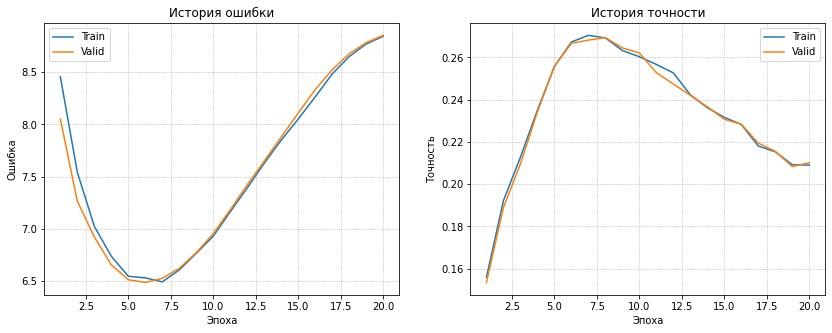


====================================== Validation ======================================/n
Ошибка на тесте: 8.8493
Точность на тесте: 0.2090

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.23      0.59      0.33      1000
           1       0.18      0.47      0.26      1000
           2       0.18      0.02      0.03      1000
           3       0.15      0.46      0.22      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.34      0.01      0.02      1000
           7       0.00      0.00      0.00      1000
           8       0.33      0.28      0.31      1000
           9       0.35      0.25      0.29      1000

    accuracy                           0.21     10000
   macro avg       0.18      0.21      0.15     10000
weighted avg       0.18      0.21      0.15     100

/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000, alpha1=1e-1, alpha2=1e-1)

####  Alpha1 = 1, Alpha2 = 1

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20| 11.4306  | 0.0931  | 11.2455  | 0.0953  | 0.069244 |   17.6   |   17.6   |
| 2/20| 10.4254  | 0.0964  | 10.2005  | 0.0985  | 0.096870 |   17.6   |   35.2   |
| 3/20|  9.5846  | 0.0985  |  9.4471  | 0.1009  | 0.087843 |   15.4   |   50.6   |
| 4/20|  9.0776  | 0.1021  |  9.0392  | 0.1049  | 0.125902 |   15.0   |   65.6   |
| 5/20|  8.8023  | 0.1094  |  8.7046  | 0.1086  | 0.099881 |   15.1   |   80.7   |
| 6/20|  8.6001  | 0.1146  |  8.5928  | 0.1171  | 0.052703 |   15.2   |   95.8   |
| 7/20|  8.5606  | 0.1203  |  8.5710  | 0.1203  | 0.049740 |   15.1   |  110.9   |
| 8/20|  8.6724  | 0.1233  |  8.6390  | 0.1259  | 0.056798 |   15.2   |  126.2   |
| 9/20|  8.6624  | 0.1363  |  8.6649  | 0.1397  | 0.071201 |   15.3   |  1

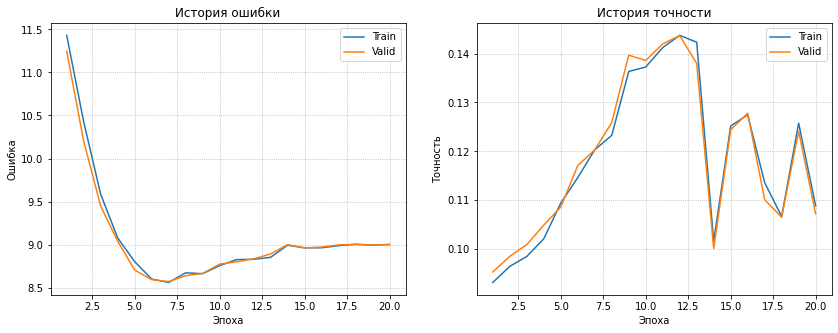


====================================== Validation ======================================/n
Ошибка на тесте: 9.0023
Точность на тесте: 0.1071

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.11      0.09      0.10      1000
           1       0.07      0.07      0.07      1000
           2       0.06      0.01      0.01      1000
           3       0.14      0.23      0.17      1000
           4       0.11      0.58      0.19      1000
           5       0.20      0.03      0.05      1000
           6       0.05      0.05      0.05      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.28      0.01      0.01      1000

    accuracy                           0.11     10000
   macro avg       0.10      0.11      0.07     10000
weighted avg       0.10      0.11      0.07     100

/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Lazarev/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000, alpha1=1, alpha2=1)

#### Вывод
Как видно из экспериментов выше, при низких коэффициентах регуляризации качество выше по сравнению с моделью без регуляризации, высокие коэффициента сильно ухудшают качество классификации. Примечательно, что лосс на train падает при увеличении коэффициентов aplha1 и aplha2, что соответствует теории, ведь регуляризация уменьшает способность модели переобучаться

### Мой эксперимент 1. Эксперимент с переобучением
Цель эксперименты посмотреть, к чему приведет сильное переобучение модели и как это отразится на качестве на валидации. 
Чтобы увеличить способность модели переобучаться, я увеличу количество слоев и нейронов в каждом слое

Sequential(
	Linear(3072, 2048, bias=True),
	ReLU(),
	Linear(2048, 1536, bias=True),
	ReLU(),
	Linear(1536, 512, bias=True),
	ReLU(),
	Linear(512, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
| Epoch |Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=======|==========|=========|==========|=========|==========|==========|==========|
|  1/100|  4.8668  | 0.3759  |  4.6963  | 0.3631  | 0.005558 |   61.5   |   61.5   |
|  2/100|  4.0072  | 0.4475  |  3.9340  | 0.4144  | 0.002468 |   61.0   |  122.5   |
|  3/100|  3.4467  | 0.4762  |  3.7473  | 0.4321  | 0.001404 |   60.7   |  183.2   |
|  4/100|  3.0850  | 0.5073  |  3.5586  | 0.4498  | 0.000940 |   63.2   |  246.4   |
|  5/100|  2.9616  | 0.5344  |  3.4600  | 0.4535  | 0.000825 |   60.5   |  306.9   |
|  6/100|  2.6282  | 0.5687  |  3.3328  | 0.4760  | 0.000782 |   60.4   |  367.3   |
|  7/100|  2.3081  | 0.5973  |  3.2721  | 0.4872  | 0.000677 |   60.3   |  427.6   |
|  8/100|  2.1379  | 0.6217  |  3.2389  | 0.4893  | 0.000967 |   60.4   |  488.0   |
|  9/100|  1.7671  | 0.6553  |  3.1740  | 0.4977  | 0.

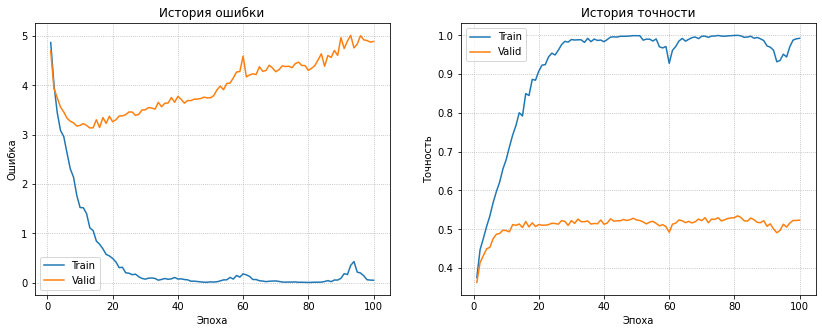


====================================== Validation ======================================/n
Ошибка на тесте: 4.8929
Точность на тесте: 0.5225

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      1000
           1       0.69      0.51      0.59      1000
           2       0.42      0.42      0.42      1000
           3       0.35      0.39      0.37      1000
           4       0.43      0.47      0.45      1000
           5       0.45      0.40      0.42      1000
           6       0.60      0.56      0.58      1000
           7       0.58      0.60      0.59      1000
           8       0.64      0.64      0.64      1000
           9       0.52      0.64      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     100

In [43]:
model = Sequential(
    Linear(3072, 2048),
    ReLU(),
    Linear(2048, 1536),
    ReLU(),
    Linear(1536, 512),
    ReLU(),
    Linear(512, 128),
    ReLU(),
    Linear(128, 10),
)
display(model)
pipeline(train_data, valid_data, model, epochs=100, lr=1e-3, optim="Adam", eps=1e-3)

#### Вывод
На графиках лосс функции выше можно наглядно увидеть, как модель переобучается: в какой-то момент лосс на валидационной выборке начинает увеличиваться. 
Это в очередной раз показывает важность подбора правильной архитектуры модели и добавление регуляризации в свои них.

### Мой эксперимент 2. Эксперимент с величиной learning rate

#### learing rate = 1e-4

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  7.7401  | 0.2405  |  7.2093  | 0.2391  | 0.007501 |   14.4   |   14.4   |
| 2/20|  6.0300  | 0.2988  |  6.0592  | 0.2865  | 0.002433 |   15.1   |   29.5   |
| 3/20|  5.3227  | 0.3402  |  5.3751  | 0.3302  | 0.001883 |   15.6   |   45.1   |
| 4/20|  5.0128  | 0.3676  |  4.9692  | 0.3534  | 0.000920 |   15.2   |   60.3   |
| 5/20|  4.5758  | 0.3831  |  4.7469  | 0.3715  | 0.000670 |   15.2   |   75.5   |
| 6/20|  4.4241  | 0.3983  |  4.5474  | 0.3831  | 0.000654 |   15.1   |   90.7   |
| 7/20|  4.1070  | 0.4114  |  4.3795  | 0.3951  | 0.000650 |   15.1   |  105.8   |
| 8/20|  4.0190  | 0.4237  |  4.2655  | 0.3991  | 0.000770 |   15.6   |  121.4   |
| 9/20|  3.7654  | 0.4331  |  4.1822  | 0.4064  | 0.000415 |   18.7   |  1

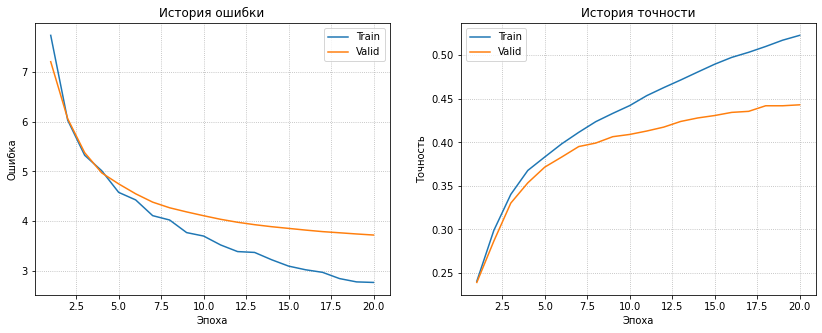


====================================== Validation ======================================/n
Ошибка на тесте: 3.6938
Точность на тесте: 0.4498

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      1000
           1       0.53      0.49      0.51      1000
           2       0.40      0.35      0.37      1000
           3       0.31      0.33      0.32      1000
           4       0.39      0.34      0.36      1000
           5       0.36      0.39      0.37      1000
           6       0.46      0.50      0.48      1000
           7       0.49      0.48      0.49      1000
           8       0.54      0.60      0.57      1000
           9       0.48      0.50      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     100

In [49]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-4, optim="Adam", eps=1e-3, batch_size=10000)

#### learing rate = 3e-4

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  6.3754  | 0.3210  |  5.8767  | 0.3109  | 0.006179 |   16.0   |   16.0   |
| 2/20|  5.1735  | 0.3608  |  5.0744  | 0.3501  | 0.003451 |   16.1   |   32.1   |
| 3/20|  4.4437  | 0.3972  |  4.6710  | 0.3808  | 0.002184 |   16.0   |   48.1   |
| 4/20|  4.0621  | 0.4196  |  4.3667  | 0.3961  | 0.001468 |   16.0   |   64.1   |
| 5/20|  3.7968  | 0.4399  |  4.1822  | 0.4055  | 0.001059 |   16.2   |   80.3   |
| 6/20|  3.6177  | 0.4593  |  3.9930  | 0.4192  | 0.000937 |   16.5   |   96.7   |
| 7/20|  3.3543  | 0.4739  |  3.8961  | 0.4294  | 0.000784 |   16.5   |  113.2   |
| 8/20|  3.1885  | 0.4906  |  3.8106  | 0.4337  | 0.000889 |   16.0   |  129.2   |
| 9/20|  2.9895  | 0.5037  |  3.7416  | 0.4410  | 0.000587 |   16.1   |  1

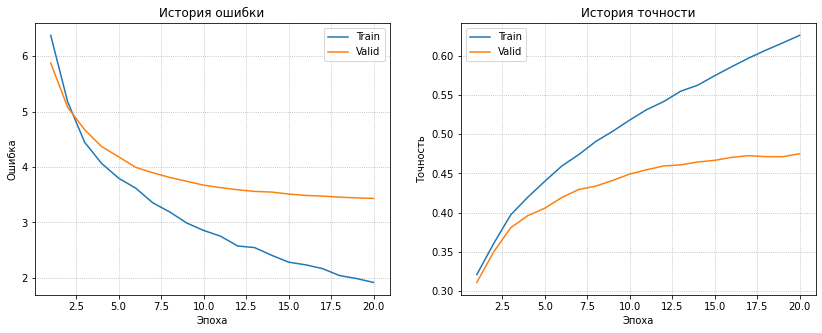


====================================== Validation ======================================/n
Ошибка на тесте: 3.3968
Точность на тесте: 0.4770

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      1000
           1       0.57      0.56      0.56      1000
           2       0.38      0.36      0.37      1000
           3       0.32      0.33      0.33      1000
           4       0.42      0.35      0.39      1000
           5       0.39      0.39      0.39      1000
           6       0.48      0.56      0.52      1000
           7       0.54      0.53      0.54      1000
           8       0.59      0.61      0.60      1000
           9       0.50      0.53      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     100

In [50]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=3e-4, optim="Adam", eps=1e-3, batch_size=10000)

#### learing rate = 1e-3

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  8.3274  | 0.2811  |  8.1637  | 0.2738  | 0.015052 |   16.3   |   16.3   |
| 2/20|  5.8828  | 0.3379  |  5.8187  | 0.3314  | 0.006974 |   16.2   |   32.4   |
| 3/20|  4.9798  | 0.3537  |  5.1042  | 0.3450  | 0.005247 |   17.2   |   49.6   |
| 4/20|  4.4943  | 0.3945  |  4.7223  | 0.3717  | 0.004579 |   18.2   |   67.8   |
| 5/20|  4.1799  | 0.4154  |  4.4240  | 0.3834  | 0.003451 |   17.3   |   85.1   |
| 6/20|  3.8263  | 0.4322  |  4.2437  | 0.3993  | 0.002837 |   16.6   |  101.7   |
| 7/20|  3.5410  | 0.4602  |  4.0739  | 0.4126  | 0.001626 |   16.3   |  118.0   |
| 8/20|  3.3072  | 0.4801  |  3.9560  | 0.4254  | 0.001357 |   16.0   |  133.9   |
| 9/20|  3.1982  | 0.4934  |  3.8797  | 0.4348  | 0.001303 |   17.0   |  1

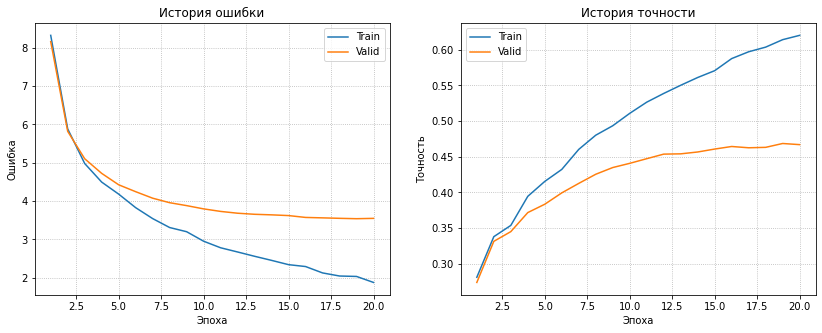


====================================== Validation ======================================/n
Ошибка на тесте: 3.5410
Точность на тесте: 0.4575

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.58      0.45      0.51      1000
           1       0.55      0.56      0.56      1000
           2       0.36      0.40      0.38      1000
           3       0.28      0.41      0.33      1000
           4       0.40      0.33      0.36      1000
           5       0.39      0.33      0.36      1000
           6       0.49      0.49      0.49      1000
           7       0.56      0.49      0.52      1000
           8       0.57      0.62      0.59      1000
           9       0.50      0.51      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.47      0.46      0.46     100

In [51]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=1e-3, optim="Adam", eps=1e-3, batch_size=10000)

#### learing rate = 3e-3

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20| 12.3850  | 0.2326  | 11.9231  | 0.2311  | 0.016279 |   15.9   |   15.9   |
| 2/20|  8.5453  | 0.3055  |  7.9026  | 0.3041  | 0.014815 |   16.8   |   32.7   |
| 3/20|  6.5214  | 0.3376  |  6.2059  | 0.3231  | 0.012205 |   15.9   |   48.7   |
| 4/20|  5.3656  | 0.3439  |  5.6874  | 0.3268  | 0.006106 |   16.1   |   64.8   |
| 5/20|  4.8856  | 0.3579  |  5.1080  | 0.3358  | 0.006071 |   16.1   |   80.9   |
| 6/20|  4.5510  | 0.3886  |  4.8080  | 0.3664  | 0.003748 |   16.0   |   96.9   |
| 7/20|  4.0984  | 0.4110  |  4.5650  | 0.3804  | 0.002723 |   16.0   |  112.9   |
| 8/20|  3.9555  | 0.4369  |  4.3982  | 0.3991  | 0.001263 |   16.0   |  128.9   |
| 9/20|  3.6942  | 0.4495  |  4.2851  | 0.4047  | 0.001269 |   16.0   |  1

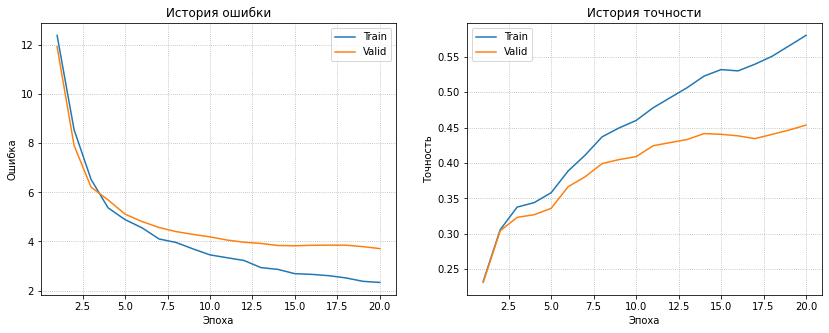


====================================== Validation ======================================/n
Ошибка на тесте: 3.6242
Точность на тесте: 0.4530

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.57      0.50      0.53      1000
           1       0.57      0.52      0.55      1000
           2       0.37      0.37      0.37      1000
           3       0.31      0.30      0.30      1000
           4       0.36      0.40      0.38      1000
           5       0.35      0.34      0.34      1000
           6       0.47      0.50      0.48      1000
           7       0.50      0.46      0.48      1000
           8       0.53      0.66      0.58      1000
           9       0.52      0.49      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     100

In [52]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
display(model)
pipeline(train_data, valid_data, model, epochs=20, lr=2e-3, optim="Adam", eps=1e-3, batch_size=10000)

#### Вывод
По итогу вывод довольно очевидный, но его нельзя назвать бесполезным: большой лосс - плохая идея, ведь модель просто не сойдется, маленький лосс - тоже не очень хорошая идея, ведь модель будет сходиться очень медленно

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?

В финальную модель я решил включить следующее:
1. Фукнция активации Sigmoid
2. Большое число нейронов
3. Маленькиое число слоев
4. Оптимизатор Adam
5. Маленький размет батча
6. Регуляризация, но с небольшим коэффициентом
7. Learning rate чуть меньше, чем в априорной модели, так как при маленькой размере батча будет сделано множество шагов оптимизации, а для них лучше, чтобы learning rate был не таким большим


====================================== Training model ======================================/n
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/50|  4.5868  | 0.4732  |  4.4865  | 0.4234  | 0.002444 |   73.5   |   73.5   |
| 2/50|  3.3896  | 0.5614  |  3.8542  | 0.4633  | 0.001327 |   82.0   |  155.5   |
| 3/50|  2.7604  | 0.6038  |  3.6990  | 0.4737  | 0.001250 |   86.6   |  242.1   |
| 4/50|  2.0379  | 0.6559  |  3.4986  | 0.4805  | 0.000618 |   84.0   |  326.1   |
| 5/50|  1.8633  | 0.6867  |  3.5120  | 0.4845  | 0.000605 |   83.9   |  410.0   |
| 6/50|  1.7694  | 0.7228  |  3.3613  | 0.4963  | 0.000630 |   83.8   |  493.8   |
| 7/50|  1.5965  | 0.7204  |  3.5052  | 0.4832  | 0.000477 |   84.9   |  578.6   |
| 8/50|  1.3049  | 0.7266  |  3.5853  | 0.4817  | 0.000381 |   86.2   |  664.9   |
| 9/50|  1.1251  | 0.7863  |  3.3339  | 0.5002  | 0.000337 |   84.9   |  7

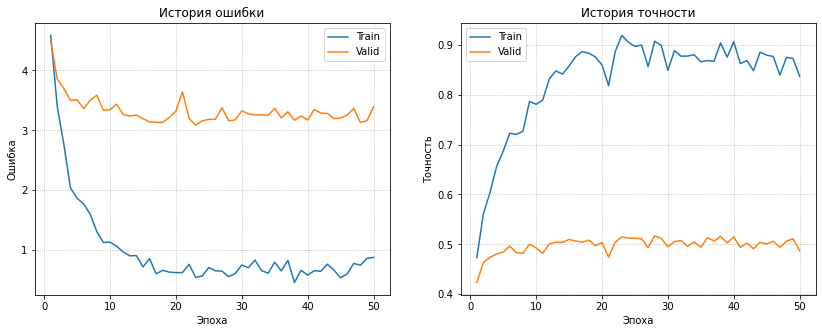


====================================== Validation ======================================/n
Ошибка на тесте: 3.3429
Точность на тесте: 0.4909

====================================== Classification report ======================================/n
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1000
           1       0.55      0.57      0.56      1000
           2       0.39      0.38      0.38      1000
           3       0.33      0.39      0.35      1000
           4       0.43      0.41      0.42      1000
           5       0.35      0.45      0.39      1000
           6       0.63      0.49      0.55      1000
           7       0.61      0.56      0.58      1000
           8       0.56      0.62      0.59      1000
           9       0.58      0.48      0.52      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     100

In [54]:
model = Sequential(
    Linear(3072, 4048),
    ReLU(),
    Linear(4048, 10),
)
pipeline(train_data, valid_data, model, epochs=50, lr=3e-4, optim="Adam", eps=1e-3, batch_size=1000, alpha1=1e-4, alpha2=1e-4)

#### Вывод
Как видно, модель полностью обучилась, так как лосс стабилизировался, - произошло это благодаря регуляризации, метрика на train выборке не поднималась выше 0.91, хотя в других экспериментах он был выше, чем 0.99. В принципе, финальная модель показала наивысшую метрику классификации, что свидетельствует о правильности выбранных методов!